In [1]:
%reload_ext autoreload
%autoreload 2

# Autoencoder

In [2]:
import torch
from src.mnist_autoencoder import Autoencoder, train
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [3]:
mnist_data = datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_data_encoder = list(mnist_data)[:4096]

In [4]:
train_loader = torch.utils.data.DataLoader(
        mnist_data_encoder, batch_size=64, shuffle=True
    )

In [5]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, train_loader, num_epochs=max_epochs)

Epoch:1, Loss:0.0747
Epoch:2, Loss:0.0650
Epoch:3, Loss:0.0641
Epoch:4, Loss:0.0436
Epoch:5, Loss:0.0290
Epoch:6, Loss:0.0246
Epoch:7, Loss:0.0194
Epoch:8, Loss:0.0151
Epoch:9, Loss:0.0135
Epoch:10, Loss:0.0124
Epoch:11, Loss:0.0134
Epoch:12, Loss:0.0114
Epoch:13, Loss:0.0101
Epoch:14, Loss:0.0096
Epoch:15, Loss:0.0084
Epoch:16, Loss:0.0085
Epoch:17, Loss:0.0075
Epoch:18, Loss:0.0076
Epoch:19, Loss:0.0070
Epoch:20, Loss:0.0069


In [5]:
# x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
# x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
# x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
# embedding = model.encoder(x)
# e1 = embedding[0] # embedding of first image
# e2 = embedding[1] # embedding of second image

In [6]:
# embedding_values = []
# for i in range(0, 10):
#     e = e1 * (i/10) + e2 * (10-i)/10
#     embedding_values.append(e)
# embedding_values = torch.stack(embedding_values)

# recons = model.decoder(embedding_values)

In [7]:
# imgs = outputs[max_epochs-1][1].detach().numpy()
# plt.subplot(1, 2, 1)
# plt.imshow(imgs[0][0])
# plt.subplot(1, 2, 2)
# plt.imshow(imgs[8][0])

In [8]:
# plt.figure(figsize=(10, 2))
# for i, recon in enumerate(recons.detach().numpy()):
#     plt.subplot(2,10,i+1)
#     plt.imshow(recon[0])
# plt.subplot(2,10,11)
# plt.imshow(imgs[8][0])
# plt.subplot(2,10,20)
# plt.imshow(imgs[0][0])

In [44]:
mnist_data_clf = list(mnist_data)[4096:4096*3]

In [45]:
len(mnist_data_clf)

8192

In [46]:
clf_train_loader = torch.utils.data.DataLoader(
        mnist_data_clf, batch_size=64, shuffle=True
    )

In [47]:
all_enc_embeddings = []
all_enc_labels = []
for data, label in clf_train_loader:
    embedding = model.encoder(data)
    all_enc_embeddings.append(embedding)
    all_enc_labels.append(label)

In [48]:
embeddings_from_enc = torch.cat(all_enc_embeddings).detach()
tgt_labels = torch.cat(all_enc_labels).detach()

In [49]:
#make a custom Dataset class and then use dataloader

In [50]:
from torch import nn
import numpy as np

In [7]:
from torch.utils.data import Dataset, DataLoader

In [52]:
class EncodedDataset(Dataset):
    def __init__(self, final_embeddings, final_labels):
        super().__init__()
        self.final_embeddings = final_embeddings
        self.final_labels = final_labels
    
    def __getitem__(self, index):
        return (
            self.final_embeddings[index],
            self.final_labels[index],
        )

    def __len__(self):
        return self.final_embeddings.shape[0]

In [119]:
ds = EncodedDataset(embeddings_from_enc, tgt_labels)

In [120]:
clf_train_loader = DataLoader(
        ds, batch_size=64, shuffle=True,
    )

In [15]:
lst =[1,2,3]
i=iter(lst)

In [20]:
i.__next__()

StopIteration: 

# Vanilla Classifier

In [42]:
from src.mnist_vanilla_classifier import VanillaClassifier, train

In [43]:
clf = VanillaClassifier()

In [22]:
from torchvision import datasets, transforms
import numpy as np

In [45]:
op = train(clf,clf_train_loader,50,64)

100%|██████████| 128/128 [00:00<00:00, 484.00it/s]


In [135]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
all_losses = []
index = 0
for i,x in enumerate(op):
    for j,y in enumerate(x):
        all_losses.append({"counter":index,"epoch":i+1,"iteration":j+1,"loss":y})
        index+=1

In [142]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

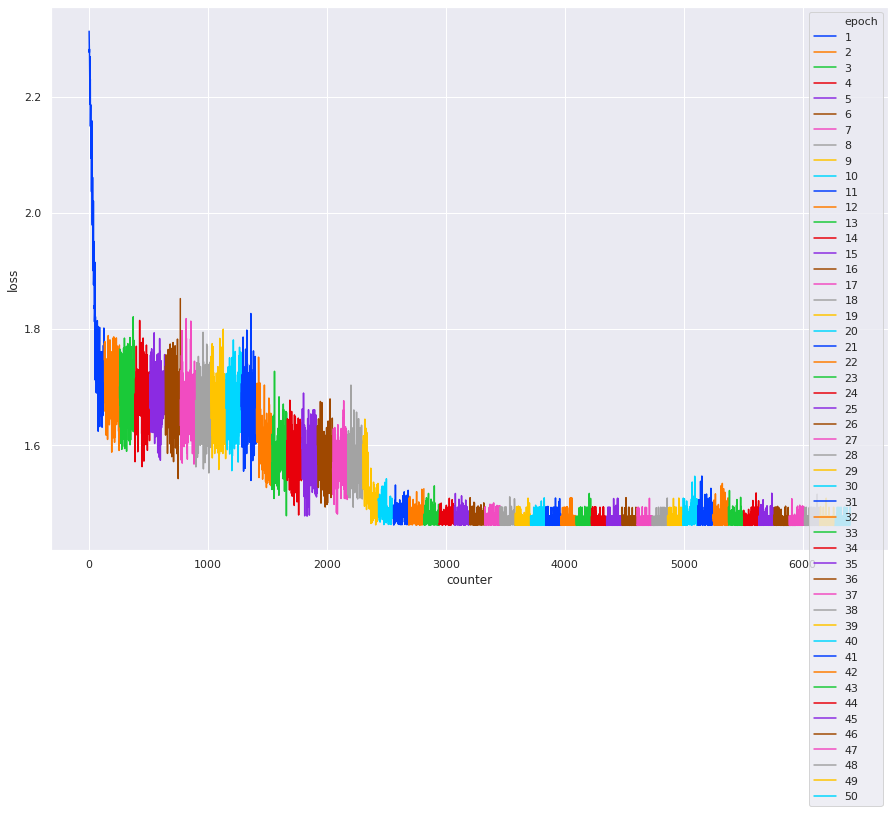

In [143]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

# test dataset

In [185]:
mnist_data_clf_test = list(mnist_data)[4096*3:4096*4]

In [186]:
len(mnist_data_clf_test)

4096

In [187]:
clf_test_loader = torch.utils.data.DataLoader(
        mnist_data_clf, batch_size=64, shuffle=True
    )

In [188]:
all_enc_embeddings = []
all_enc_labels = []
for data, label in clf_test_loader:
    embedding = model.encoder(data)
    all_enc_embeddings.append(embedding)
    all_enc_labels.append(label)
#     all_test_labels.append(torch.nn.functional.one_hot(label))

In [189]:
embeddings_from_enc = torch.cat(all_enc_embeddings).detach()
tgt_labels = torch.cat(all_enc_labels).detach()

In [190]:
#make a custom Dataset class and then use dataloader

In [191]:
ds_test = EncodedDataset(embeddings_from_enc, tgt_labels)

In [204]:
clf_test_loader = DataLoader(
        ds_test, batch_size=64, shuffle=True
    )

In [206]:
from tqdm import tqdm

In [226]:
res = []
for data in tqdm(clf_test_loader):
    img, label = data
    recon = clf(img)
    _, preds = torch.max(recon, 1)
    bool_tensor = preds == label
    res.append(torch.stack([label,bool_tensor,preds],dim=1))

  0%|          | 0/64 [00:00<?, ?it/s]/home/pranjal/miniconda3/envs/gcn/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 64/64 [00:00<00:00, 620.69it/s]


In [227]:
all_res = torch.cat(res,dim=0)

In [228]:
import numpy as np

In [230]:
df_test_res = pd.DataFrame(all_res.numpy(),columns=["class","res","pred_class"])

In [233]:
# df_test_res.groupby(["class","res"]).agg({"res":len})

In [238]:
confusion_matrix = pd.crosstab(df_test_res['class'], df_test_res['pred_class'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,395,0,5,0,0,2,1,2,0,0
1,0,468,3,0,0,0,0,0,2,0
2,2,4,376,5,2,0,1,6,5,1
3,0,1,4,420,1,4,0,1,1,4
4,1,2,0,1,345,0,5,0,2,9
5,2,2,0,6,1,362,3,0,6,4
6,0,1,8,0,0,2,373,0,0,0
7,1,0,0,4,1,0,0,410,5,4
8,0,2,4,5,1,3,0,0,391,2
